In [2]:
import numpy as np
from qiskit import *
import math
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, QuantumRegister
from sympy import *
from math import pi
from qiskit.circuit import Parameter
%matplotlib inline
from scipy.integrate import odeint,solve_ivp
import pandas as pd
from qiskit.circuit.library.standard_gates import HGate
import timeit

In [3]:
# Visualization packages
from qiskit.visualization import plot_state_city, plot_bloch_vector,plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

In [4]:
# Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')
backend_vec = Aer.get_backend('statevector_simulator')
backend_uni = Aer.get_backend('unitary_simulator')

In [5]:
# Register circuit (total qubits in the network)
q_1 = QuantumRegister(4)
c_1 = ClassicalRegister(4) 
qt = QuantumRegister(4)
ct = ClassicalRegister(4) 
qt2 = QuantumRegister(8)
ct2 = ClassicalRegister(8) 
# Register circuit (total qubits in the network)
q2 = QuantumRegister(16) 
c2 = ClassicalRegister(16)

In [87]:
#parameters
N_shots = 5000
N_time = 10000

# Using Quantum Circuits to solve Ordinary Differential Equations (Euler's Method)

Here we will use an algorithm from arXiv:2012.09469v1 "Quantum Algorithms for Solving Ordinary Differential Equations" by Zanger $\textit{et. al.}$

Consider the following Ordinary Differential Equation (ODE):

$$ \frac{d}{dt}u(t) =  k f(u(t)) =  \begin{pmatrix} u_2(t) \\ -u_1(t)\end{pmatrix}, $$

where k = 1.


Euler's method:
$u(t + \Delta t) \sim u(t) + k \Delta t f(u(t)) $ 


The algorithm they devised will take advantage of a  digital quantum computation.

Since each qubit represents two states 0 and 1, there is a total possibility of $2^n$ states to utilize if we have n amount of qubits. This means $| a \rangle = | a_{n-1} \rangle| a_{n-2} \rangle ...| a_0 \rangle$ in the binary representation. The number a can be broken down as a = $2^0a_0 + 2^1a_1 + ... + 2^{n-1}a_{n-1}$, or the number can be represented in two's complament as a = $2^0a_0 + 2^1a_1 + ... +  2^{n-2}a_{n-2} - 2^{n-1}a_{n-1}$

For an N-dimensional ODE, we want each component represent by $| a \rangle$. For example, $\vec{f}(\vec{u}(t)) \sim (u_1(t), u_2(t))^{\top}$ would mean that we need a register $| a' \rangle \rightarrow |u_1(t)\rangle, | b' \rangle \rightarrow |u_2(t)\rangle.$

## How to add two numbers

Let's consider that $\hat{X} |x\rangle$ yields a real number and $\hat{X}$ is the "position" operator. Its "momentum" conjugate is the fourier transform ($\hat{F}$) such that $\hat{P} = \hat{F}^{\dagger}\hat{X}\hat{F}$. We will assume $\hat{P} = \hat{H}$ where $\hat{H}$ is the Hamiltonian.


A continuous variable quantum state $| a \rangle$ is

$$ e^{-ic\hat{H}}|a\rangle  = | a + c \rangle \ \ \  (1)$$

where $\hat{H}$ is the Hamiltonian, and c is the shift in the Hamiltonian. 

For Eq. (1) to describe an integer interaction then, on a digital quantum computer schematic, we can take advantage of the FOurier transform

$$ \hat{F}^{\dagger} e^{-2\pi i c\hat{X}/2^n}\hat{F} = |a\rangle  = | a + c \ \ mod (2^n) \rangle \ \ \ (2).$$

However, we only want to apply
We can decompose the following:
$$ e^{-2\pi i c\hat{X}/2^n} = \bigotimes_{k=0}^{n-1} \sum_{a_k = {0,1}} e^{-2\pi i c a_k /2^{n-k}} |a_k \rangle \langle a_k | \ \ \ (3), $$
where the quantum gate $R_{\phi}$ gate (or $R_{Z}$ gate) can represent the exponential inside Eq. (3). This can be extended to $|a, b \rangle \rightarrow | a, a + b \ \ mod(2^n) \rangle$. 



## Quantum Fourier Transform functions 

In [7]:
#(taken from qiskit documentation)
def qft_rotations(circuit, n, n1):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    if n1 >= n:
        return circuit
    #print(n1)
    circuit.h(n1)
    for qubit in reversed(range(n)):
        #print(qubit)
        if qubit > n1:
            circuit.cp((2*np.pi)/2**(qubit-n1+2), qubit, n1)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    #print(n1)
    n1 += 1
    qft_rotations(circuit, n, n1)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n, 0)
    #swap_registers(circuit, n)
    return circuit
def qft_inv(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    circuit.append(invqft_circ, circuit.qubits[:n])
    #swap_registers(circuit, n)
    return circuit.decompose()


In [8]:
def add_fourier_way(circuit, na, nb,n,start,stop):
    # na: number of qubits for the ath number
    # nb: number of qunits for the bth number
    # n: total number of qubits 
    # start: the qubit to start the addition
    # stop: total number of qubits for the ath number
    if nb == 0:
        return circuit
    nb -= 1
    na -= 1
    for qubit in range(start, stop):
        #print('hi',qubit,st)
        circuit.cp((2*np.pi)/2**(qubit-start+1), qubit  , n - (nb+1))
    #print(nb)
    #circuit.barrier()
    start += 1
    add_fourier_way(circuit, na, nb,n,start,stop)
    
    
def sub_fourier_way(circuit, na, nb,n,start,stop):
    # na: number of qubits for the ath number
    # nb: number of qunits for the bth number
    # n: total number of qubits 
    # start: the qubit to start the addition
    # stop: total number of qubits for the ath number
    if nb == 0:
        return circuit
    nb -= 1
    na -= 1
    for qubit in range(start, stop):
        #print('hi',qubit,st)
        circuit.cp((-2*np.pi)/2**(qubit-start+1), qubit  , n - (nb+1))
    #print(nb)
    
    start += 1
    circuit.barrier()
    sub_fourier_way(circuit, na, nb,n,start,stop)
    

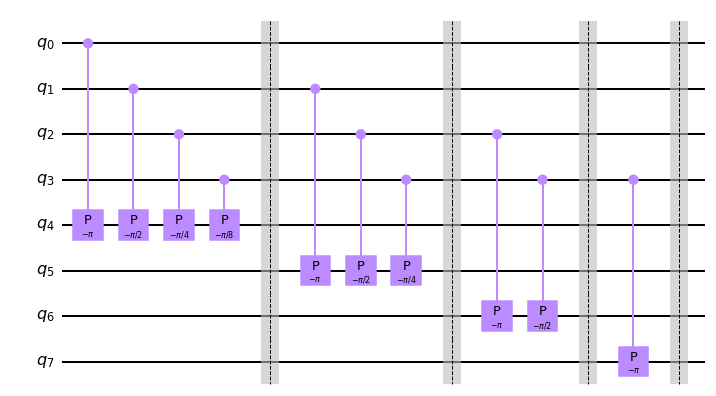

In [9]:
qctt = QuantumCircuit(8)
sub_fourier_way(qctt, 4, 4,8,0,4)
qctt.draw('mpl')

In [10]:
def add_qc(circuit, na, nb,n,start,stop):
    add_fourier_way(circuit, na, nb,n,start,stop)
    return circuit
def sub_qc(circuit, na, nb,n,start,stop):
    sub_fourier_way(circuit, na, nb,n,start,stop)
    return circuit

In [11]:
def divide_by_two(circuit,n,qb_vec):
    dum_cir = QuantumCircuit(n,name='number/2')
    dum_cir.cx(0,n-1)
    for qubit in range(n//2):
        dum_cir.swap(0,n-qubit-1)
    circuit.append(dum_cir,qb_vec)
    return circuit

## Divide by 2 in two's complament

The circuit in this section will convert the binary form of a 4-bit into two's complement that's only shifted to the right by 1 bit. The action perform here is known as an arithmetic shift to the left, which rounds to -infinity and then divides by two. 

In two's complement, in floating point form, the number a is given as 

$$ a = a_{3}a_{2}a_{1}.a_{0} = -2^{2}a_{3} + 2^{1}a_2 + 2^{0}a_{1} + 2^{-1}a_{0}.$$

This form is different than the initial input wavefunction that we will put into the circuit. We will now list the arbitrary:

binary input    |     two's complament      |      number     |  combination #
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
   0000         |           000.0           |       0.0       |       1  

   0001         |           010.0           |       2.0       |       2  

   0010         |           000.1           |       0.5       |       3  

   0011         |           010.1           |       2.5       |       4  

   0100         |           001.0           |       1.0       |       5  

   0101         |           011.0           |       3.0       |       6  

   0110         |           001.1           |       1.5       |       7  

   0111         |           011.1           |       3.5       |       8  

   1000         |           110.0           |      -2.0       |       9  

   1001         |           100.0           |      -4.0       |       10 

   1010         |           110.1           |      -1.5       |       11 

   1011         |           100.1           |      -3.5       |       12 

   1100         |           111.0           |      -1.0       |       13 

   1101         |           101.0           |      -3.0       |       14 

   1110         |           111.1           |      -0.5       |       15 

   1111         |           101.1           |      -2.5       |       16 



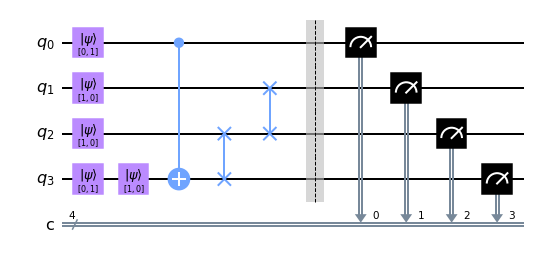

In [12]:
qct1 = QuantumCircuit(4,4)

qct1.initialize([0,1],0)
qct1.initialize([1,0],1)
qct1.initialize([1,0],2)
qct1.initialize([0,1],3)

qct1.initialize([1,0],3)
qct1.cx(0,3)
qct1.swap(2,3)
qct1.swap(1,2)

#circtf = qft(QuantumCircuit(4,name='qft'),4)
#qct1.append(circtf,[0,1,2,3])
#
#qct1.rz((2*np.pi*(1))/2**(4-0),0)
#qct1.rz((2*np.pi*(1))/2**(4-1),1)
#qct1.rz((2*np.pi*(1))/2**(4-2),2)
#qct1.rz((2*np.pi*(1))/2**(4-3),3)
#
#circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
#qct1.append(circtfinv,[0,1,2,3])
qct1.barrier()


qct1.measure(range(4),range(4))

qct1.draw('mpl')

In [13]:
results = execute(qct1,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()
#plot_histogram(counts)
max(counts, key=counts.get)

'0011'

The code above first rounds the number to negative infinity then divide a two's complement number by two. The result is a two's complament number such that abc.d $\rightarrow$ a'b'c'.d'. 

In [14]:
def divide_4bit_two(circuit,qb_vec):
    dum_cir = QuantumCircuit(4,name='number/2')
    dum_cir.initialize([1,0],3)
    dum_cir.cx(0,3)
    dum_cir.swap(2,3)
    dum_cir.swap(1,2)
    circuit.append(dum_cir,qb_vec)
    return circuit

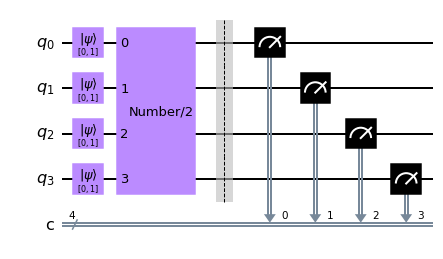

In [150]:
qct1 = QuantumCircuit(4,4)

qct1.initialize([0,1],0)
qct1.initialize([0,1],1)
qct1.initialize([0,1],2)
qct1.initialize([0,1],3)


divide_4bit_two(qct1,[0,1,2,3])

qct1.barrier()


qct1.measure(range(4),range(4))

qct1.draw('mpl')

In [151]:
results = execute(qct1,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()
test_divide = max(counts, key=counts.get)

In [157]:
two2dec('1111')/2

-0.5

In [155]:
two2dec(test_divide[3]+test_divide[2]+test_divide[1]+test_divide[0])/2

-0.5

# Testing addition gate

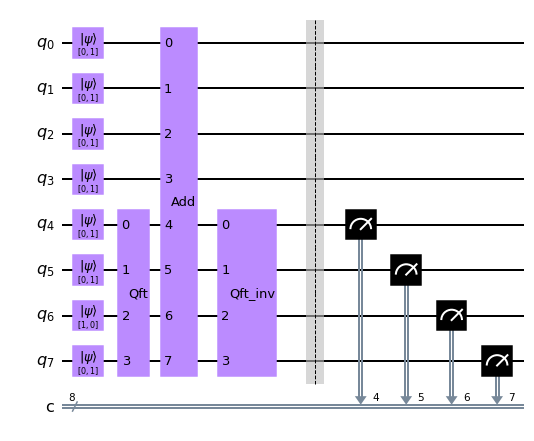

In [166]:
qct1 = QuantumCircuit(8,8)
## b
qct1.initialize([0,1],0)
qct1.initialize([0,1],1)
qct1.initialize([0,1],2)
qct1.initialize([0,1],3)
## a
qct1.initialize([0,1],4)
qct1.initialize([0,1],5)
qct1.initialize([1,0],6)
qct1.initialize([0,1],7)


circtf = qft(QuantumCircuit(4,name='qft'),4)
qct1.append(circtf,[4,5,6,7])

circq = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
qct1.append(circq,[0,1,2,3,4,5,6,7])

circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
qct1.append(circtfinv,[4,5,6,7])
qct1.barrier()



qct1.measure(range(4,8),range(4,8))

qct1.draw('mpl')

In [163]:
results = execute(qct1,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()

add_test = max(counts, key=counts.get)

In [164]:
btest = two2dec('1111')/2
atest = two2dec('1101')/2
addsol = two2dec(add_test[3]+add_test[2]+add_test[1]+add_test[0])/2
print('a =',atest,';','b =',btest,';','(a + b) =', addsol,';','(a + b) =', atest + btest)


a = -1.5 ; b = -0.5 ; (a + b) = -2.5 ; (a + b) = -2.0


## Testing subtraction gate

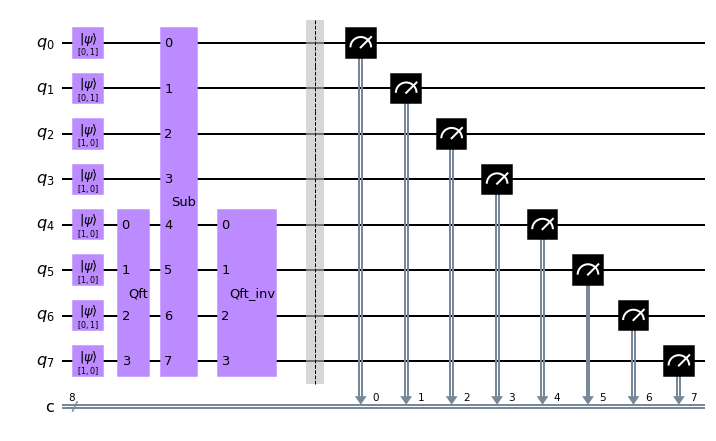

In [147]:
qct1 = QuantumCircuit(8,8)

qct1.initialize([0,1],0)
qct1.initialize([0,1],1)
qct1.initialize([1,0],2)
qct1.initialize([1,0],3)

qct1.initialize([1,0],4)
qct1.initialize([1,0],5)
qct1.initialize([0,1],6)
qct1.initialize([1,0],7)

circtf = qft(QuantumCircuit(4,name='qft'),4)
qct1.append(circtf,[4,5,6,7])



circq = sub_qc(QuantumCircuit(8,name='sub'), 4, 4, 8,0,4)
qct1.append(circq,[0,1,2,3,4,5,6,7])

circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
qct1.append(circtfinv,[4,5,6,7])
qct1.barrier()



qct1.measure(range(8), range(8))

qct1.draw('mpl')

In [148]:
results = execute(qct1,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()
#plot_histogram(counts)
sub_test = max(counts, key=counts.get)

In [149]:
btest = two2dec('1100')/2
atest = two2dec('0010')/2
subsol = two2dec(sub_test[3]+sub_test[2]+sub_test[1]+sub_test[0])/2
print('a =',atest,';','b =',btest,';','(a - b) =', subsol,';','(a - b) =', atest - btest)


a = 1.0 ; b = -2.0 ; (a - b) = 3.0 ; (a - b) = 3.0


# Classical Solver

In [15]:
def classical_way(t,z):
    #y is a vector [u1(0),u2(0)]
    x,y = z
    dydt = [y,-x]
    return dydt

In [16]:
y0 = [0,-1]
time = np.linspace(0,7,N_time)
sol = solve_ivp(classical_way, [0,7],y0, method='RK45',dense_output=True, t_eval=time)

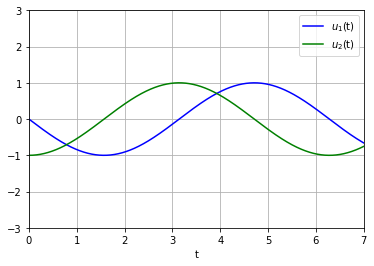

In [17]:
plt.plot(sol.t, sol.y[0, :], '-b', label='$u_1$(t)')
plt.plot(sol.t, sol.y[1, :], '-g', label='$u_2$(t)')
#plt.plot(time, z.T)
plt.legend(loc='best')
#plt.legend(['$u_1$(t)', '$u_2$(t)'], shadow=True)
plt.xlabel('t')
plt.ylim(-3,3)
plt.xlim(0,7)
plt.grid()
plt.show()

We are gonig to try to reproduce the paper's example such that $u_1(t = 0) = 0.0$ and $u_2(t = 0) = -1.0$. This involes knowing the address of a number, for example, the number 6 in binary form is 110. Thus, to represent a number in a quantum circuit, we need 3 qubits prepared in the state $|1\rangle \otimes |1\rangle \otimes |0\rangle$.

The initial condition for a 4bit circuit in two's complament form is $|u_1(t = 0)\rangle = |0000\rangle$ and $|u_2(t = 0)\rangle = |1111\rangle$.

## ODE Solver Quantum Circuit

Here we want to create the quantum circuit version of the above ODE. Let's first hard code this and then make it more general for a 4bit ODE solver. 

In [ ]:
# The first slice of Euler's method
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

qct.barrier()


#f1(u) = u_2
circtf = qft(QuantumCircuit(4,name='qft'),4)
qct.append(circtf,[8,9,10,11])


circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
qct.append(circadd, [4,5,6,7,8,9,10,11])


circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
qct.append(circtfinv,[8,9,10,11])
qct.barrier()



#f2(u) = u_1

circtf2 = qft(QuantumCircuit(4,name='qft'),4)
qct.append(circtf2,[12,13,14,15])

circadd2 = sub_qc(QuantumCircuit(8,name='sub'), 4, 4, 8,0,4)
qct.append(circadd2, [0,1,2,3,12,13,14,15])

circtfinv2 = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
qct.append(circtfinv2,[12,13,14,15])

qct.barrier()


divide_4bit_two(qct,[8,9,10,11])
divide_4bit_two(qct,[12,13,14,15])
qct.barrier()

## Add f1(u) to u_1

circtf = qft(QuantumCircuit(4,name='qft'),4)
qct.append(circtf,[0,1,2,3])

circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
qct.append(circadd, [8,9,10,11,0,1,2,3])


circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
qct.append(circtfinv,[0,1,2,3])
qct.barrier()


## Add f2(u) to u_2



circtf = qft(QuantumCircuit(4,name='qft'),4)
qct.append(circtf,[4,5,6,7])


circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
qct.append(circadd, [12,13,14,15,4,5,6,7])


circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
qct.append(circtfinv,[4,5,6,7])
qct.barrier()



qct.measure(range(16),range(16))
#qct.measure(range(8,12),range(8,12))

qct.draw('mpl')

In [ ]:
results = execute(qct,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()
# plot_histogram(counts)
max(counts, key=counts.get)

The output with the highest probability should be the answer to the first step of this differential equation. Therefore,
the answer should be $u_1 = 1111$ and $u_2 = 1110$.


$$ u_1 = -2^{2}a_{3} +  2^{1}a_{2} + 2^{0}a_{1} + 2^{-1}a_{0} = -4(1)  + 2(1) + 1(1) + 0.5(1) = -0.5,$$

$$ u_2 = -2^{2}a_{3} + 2^{1}a_{2} + 2^{0}a_{1} + 2^{-1}a_{0} = -4(1) + 2(1) + 1(1) + 0.5(0) = -1.0$$

This answer is in agreement with the classical solver at this time step. 

### Time slice

In [18]:
def time_4bit_slice(circuit,n):
    
    
    if n != 16:
        return Print('Incorrect total qubit number')
    
    #f1(u) = u_2
    circtf = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf,[8,9,10,11])


    circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
    circuit.append(circadd, [4,5,6,7,8,9,10,11])


    circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv,[8,9,10,11])
    circuit.barrier()



    #f2(u) = u_1

    circtf2 = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf2,[12,13,14,15])

    circadd2 = sub_qc(QuantumCircuit(8,name='sub'), 4, 4, 8,0,4)
    circuit.append(circadd2, [0,1,2,3,12,13,14,15])

    circtfinv2 = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv2,[12,13,14,15])

    circuit.barrier()

    divide_4bit_two(circuit,[8,9,10,11])
    divide_4bit_two(circuit,[12,13,14,15])
    circuit.barrier()

    ## Add f1(u) to u_1

    circtf = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf,[0,1,2,3])

    circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
    circuit.append(circadd, [8,9,10,11,0,1,2,3])


    circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv,[0,1,2,3])
    circuit.barrier()


    ## Add f2(u) to u_2



    circtf = qft(QuantumCircuit(4,name='qft'),4)
    circuit.append(circtf,[4,5,6,7])


    circadd = add_qc(QuantumCircuit(8,name='add'), 4, 4, 8,0,4)
    circuit.append(circadd, [12,13,14,15,4,5,6,7])


    circtfinv = qft_inv(QuantumCircuit(4,name='qft_inv'),4)
    circuit.append(circtfinv,[4,5,6,7])
    circuit.barrier()



    ##### Compute the Second Slice


   
    return circuit

In [50]:
# The second slice of Euler's method
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

qct.barrier()


time_4bit_slice(qct,16)
 ## reset the ancilla bits
    # 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)
qct.barrier()
time_4bit_slice(qct,16)


qct.measure(range(16),range(16))
#qct.measure(range(8,12),range(8,12))

results = execute(qct,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()

max(counts, key=counts.get)

'0000111101110111'


For the second time integration step we get $u_1 = 1110$ and $u_2 = 1110$.

$$ u_1 = -2^{2}a_{3}  + 2^{1}a_{2} + 2^{0}a_{1} + 2^{-1}a_{0} = -4(1) + 2(1) + 1(1) + 0.5(0) = -1.0$$

$$ u_2 = -2^{2}a_{3}  + 2^{1}a_{2} + 2^{0}a_{1} + 2^{-1}a_{0} = -4(1) + 2(1) + 1(1) + 0.5(0) = -1.0$$

In [75]:
# The third slice of Euler's method
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)

qct.barrier()


time_4bit_slice(qct,16)
 ## reset the ancilla bits
    # 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)
qct.barrier()
time_4bit_slice(qct,16)

 ## reset the ancilla bits
    # 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)
qct.barrier()
time_4bit_slice(qct,16)
qct.measure(range(8),range(8))
#qct.measure(range(8,12),range(8,12))

results = execute(qct,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()

max(counts, key=counts.get)

'0000000011111011'

In [82]:
# The fourth slice of Euler's method
qct = QuantumCircuit(q2,c2)
# u_1(0)= 0 =   -2^3a_3 + 2^2a_2 + 2^1a_1 + a_0
qct.initialize([1,0],0) # a_3 = 0
qct.initialize([1,0],1) # a_2 = 0
qct.initialize([1,0],2) # a_1 = 0
qct.initialize([1,0],3) # a_0 = 0
#u_2(0) = -1 = -2^3b_3 + 2^2b_2 + 2^1b_1 + b_0
qct.initialize([0,1],4) # b_3 = 1
qct.initialize([0,1],5) # b_2 = 1
qct.initialize([0,1],6) # b_1 = 1
qct.initialize([1,0],7) # b_0 = 0
# 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)
# garbage bits
#qct.initialize([1,0],16)
#qct.initialize([1,0],17)
#qct.initialize([1,0],18)
#qct.initialize([1,0],19)
qct.barrier()


time_4bit_slice(qct,16)
 ## reset the ancilla bits
    # 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)
qct.barrier()
time_4bit_slice(qct,16)

 ## reset the ancilla bits
    # 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)
qct.barrier()
time_4bit_slice(qct,16)

 ## reset the ancilla bits
    # 0 ancilla
qct.initialize([1,0],8)
qct.initialize([1,0],9)
qct.initialize([1,0],10)
qct.initialize([1,0],11)
# 0 ancilla
qct.initialize([1,0],12)
qct.initialize([1,0],13)
qct.initialize([1,0],14)
qct.initialize([1,0],15)
qct.barrier()
time_4bit_slice(qct,16)

qct.measure(range(8),range(8))
#qct.measure(range(8,12),range(8,12))

results = execute(qct,backend = backend_sim, shots = N_shots).result()
#abs(results.get_statevector())
counts = results.get_counts()

max(counts, key=counts.get)

'0000000010000000'

The problem here is that I need more points to determine if this violates one of the approximations we imposed on our system. Specifically, the higest probability is the correct answer. However, this only works if this outcome has a probability much greater than anyother outcome. As you see above this is not the case for 0000000000000000, and increasing the trials is taxing. At N_shots = 5500 this took roughly 10 minutes to compute. It took 30 mins to compute the fourth time slice with N_shots = 15000 trials, and the result was off from Zanger $\textit{et. al.}$ paper. 

## WORK TO BE CONTINUED (soft coding a 4-bit ODE solver)

In [51]:
def ode_integration_part(circuit,n,ts,time_slice):
    if n != 16:
        return circuit
    if ts > time_slice:
        return circuit
    #time_4bit_slice(circuit,16)
    #circuit.barrier()
    circuit.initialize([1,0],8)
    circuit.initialize([1,0],9)
    circuit.initialize([1,0],10)
    circuit.initialize([1,0],11)
    circuit.initialize([1,0],12)
    circuit.initialize([1,0],13)
    circuit.initialize([1,0],14)
    circuit.initialize([1,0],15)
    circuit.barrier()
    time_4bit_slice(circuit,16)
    circuit.barrier()
    ts += 1

In [41]:
# The first slice of Euler's method

#qct.barrier()
for ii in range(2):
    circuit = QuantumCircuit(16,16)
        # u_1(0)= 0.0 =   -2^2a_3 + 2^1a_2 + 2^0a_1 + 2^{-1}a_0
    circuit.initialize([u1_int[0],u1_int[1]],0) # a_3 = 0
    circuit.initialize([u1_int[2],u1_int[3]],1) # a_2 = 0
    circuit.initialize([u1_int[4],u1_int[5]],2) # a_1 = 0
    circuit.initialize([u1_int[6],u1_int[7]],3) # a_0 = 0
    #u_2(0) = -1.0 = -2^2b_3 + 2^1b_2 + 2^0b_1 + 2^{-1}b_0
    circuit.initialize([u2_int[0],u2_int[1]],4) # b_3 = 1
    circuit.initialize([u2_int[2],u2_int[3]],5) # b_2 = 1
    circuit.initialize([u2_int[4],u2_int[5]],6) # b_1 = 1
    circuit.initialize([u2_int[6],u2_int[7]],7) # b_0 = 0
    ## Initialize ancilla qubits
    #circuit.initialize([1,0],8) # b_3 = 1
    #circuit.initialize([1,0],9) # b_2 = 1
    #circuit.initialize([1,0],10) # b_1 = 1
    #circuit.initialize([1,0],11) # b_0 = 0
    #circuit.initialize([1,0],12) # b_3 = 1
    #circuit.initialize([1,0],13) # b_2 = 1
    #circuit.initialize([1,0],14) # b_1 = 1
    #circuit.initialize([1,0],15) # b_0 = 0
    for jj in range(2):
        ode_integration_part(circuit,16,0,jj)
    circuit.measure(range(16),range(16))
#circuit.measure(range(16),range(16))
#qct.measure(range(8,12),range(8,12))
circuit.draw('mpl')
results = execute(circuit,backend = backend_sim, shots = N_shots).result()

counts = results.get_counts()
ool =max(counts, key=counts.get)

two2dec(ool[15]+ool[14]+ool[13]+ool[12])/2
two2dec(ool[11]+ool[10]+ool[9]+ool[8])/2

-1.0

In [42]:
two2dec(ool[15]+ool[14]+ool[13]+ool[12])/2 #u1
#two2dec(ool[11]+ool[10]+ool[9]+ool[8])/2  #u2

-1.0

In [45]:
## I had help from the internet. Here is the overstack form where I got this function https://stackoverflow.com/questions/1604464/twos-complement-in-python
def two2dec(s):
      if s[0] == '1':
        return -1 * (int(''.join('1' if x == '0' else '0' for x in s), 2) + 1)
      else:
        return int(s, 2)

In [46]:
def ode_integration(n,final_time_ind,qq,cc,u1_int,u2_int,ode_int):
    #u1_init and u2_int is a 8-d vector, e.g. u1_int = [bit_(n-1),bit_(n-1),bit_(n-2),_(n-2),...,bit_(0),bit_(0) ]
    # The following schematic only records the solution starting at the first time slice but never at the initial condition. Therefore
    # we need to 'manually' input the initial condition ourselves using ode_int. The argument ode_int is a 2-D vector such that ode_int = [u1(0), u2(0)].

    if n != 16:
        return Print('Number of Qubits does not align')
    string_solution = []
    solution_u1 = [ode_int[0]]
    solution_u2 = [ode_int[1]]
    # The first slice of Euler's method
    #circuit = QuantumCircuit(qq,cc)

    
    for ii in range(final_time_ind):
        circuit = QuantumCircuit(qq,cc)
        # u_1(0)= 0.0 =   -2^2a_3 + 2^1a_2 + 2^0a_1 + 2^{-1}a_0
        circuit.initialize([u1_int[0],u1_int[1]],0) # a_3 = 0
        circuit.initialize([u1_int[2],u1_int[3]],1) # a_2 = 0
        circuit.initialize([u1_int[4],u1_int[5]],2) # a_1 = 0
        circuit.initialize([u1_int[6],u1_int[7]],3) # a_0 = 0
        #u_2(0) = -1.0 = -2^2b_3 + 2^1b_2 + 2^0b_1 + 2^{-1}b_0
        circuit.initialize([u2_int[0],u2_int[1]],4) # b_3 = 1
        circuit.initialize([u2_int[2],u2_int[3]],5) # b_2 = 1
        circuit.initialize([u2_int[4],u2_int[5]],6) # b_1 = 1
        circuit.initialize([u2_int[6],u2_int[7]],7) # b_0 = 0
        ## Initialize ancilla qubits
        #circuit.initialize([1,0],8) # b_3 = 1
        #circuit.initialize([1,0],9) # b_2 = 1
        #circuit.initialize([1,0],10) # b_1 = 1
        #circuit.initialize([1,0],11) # b_0 = 0
        #circuit.initialize([1,0],12) # b_3 = 1
        #circuit.initialize([1,0],13) # b_2 = 1
        #circuit.initialize([1,0],14) # b_1 = 1
        #circuit.initialize([1,0],15) # b_0 = 0
        for jj in range(final_time_ind):
            ode_integration_part(circuit,16,0,jj)
        circuit.measure(range(16),range(16))
        results = execute(circuit,backend = backend_sim, shots = N_shots).result()
        counts = results.get_counts()
        string_solution.append(max(counts, key=counts.get))
    for iii in range(len(string_solution)):
        solution_u2.append(two2dec(string_solution[iii][11]+string_solution[iii][10]+string_solution[iii][9]+ string_solution[iii][8])/2)
        solution_u1.append(two2dec(string_solution[iii][15]+string_solution[iii][14]+string_solution[iii][13]+string_solution[iii][12])/2)  
    return solution_u1, solution_u2, string_solution

In [47]:
nslice = 4
u1_int = [1,0,1,0,1,0,1,0] # u1(0) = 0.0
u2_int = [0,1,0,1,0,1,1,0] # # u2(0) = -1.0
u1u2_int = [0.0,-1.0]
time_qc = np.linspace(0,0.5*nslice,nslice+1)
solu1,solu2,sol_string = ode_integration(16,nslice,q2,c2,u1_int,u2_int,u1u2_int)

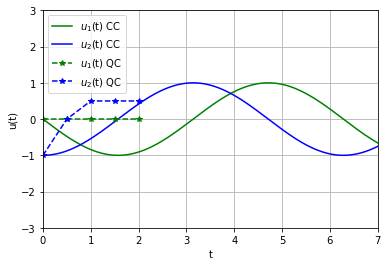

In [48]:
plt.plot(sol.t, sol.y[0, :], '-g', label='$u_1$(t) CC')
plt.plot(sol.t, sol.y[1, :], '-b', label='$u_2$(t) CC')
plt.plot(time_qc, solu1, '*--g', label='$u_1$(t) QC')
plt.plot(time_qc, solu2, '*--b', label='$u_2$(t) QC')

#plt.plot(time, z.T)
plt.legend(loc='best')
#plt.legend(['$u_1$(t)', '$u_2$(t)'], shadow=True)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.ylim(-3,3)
plt.xlim(0,7)
#plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.grid()
plt.savefig('ODE_Solver2.pdf')  
plt.show()

In [49]:
sol_string

['0000000000000000',
 '0000000010000000',
 '0000000010000000',
 '0000000010000000']